In [1]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Analyze

In [2]:
### Input ###
Dataset = "COMPAS"
Directory = "/Users/simondn/Documents/RashomonActiveLearning/Results/OptimalThreshold/"

### All values ###
ThresholdValuesALL = pd.read_csv(os.path.join(Directory,Dataset,"Processed/ThresholdValuesStorage.csv"))
Epsilon_F1ScoreALL = pd.read_csv(os.path.join(Directory,Dataset,"Processed/Epsilon_F1ScoreStorage.csv"))
Epsilon_ClassAccuracyALL = pd.read_csv(os.path.join(Directory,Dataset,"Processed/Epsilon_ClassAccuracyStorage.csv"))

### Average Values ###
ThresholdValues_Mean = np.mean(ThresholdValuesALL, axis =0)
Epsilon_F1Score_Mean = np.mean(Epsilon_F1ScoreALL, axis =0)
Epsilon_ClassAccuracy_Mean = np.mean(Epsilon_ClassAccuracyALL, axis =0)

In [3]:
print(ThresholdValuesALL.shape[0])
print(Epsilon_F1ScoreALL.shape[0])
print(Epsilon_ClassAccuracyALL.shape[0])
# np.where(Epsilon_F1Score_Mean == np.max(Epsilon_F1Score_Mean))

62
62
62


# Accuracy by Rashomon Threshold

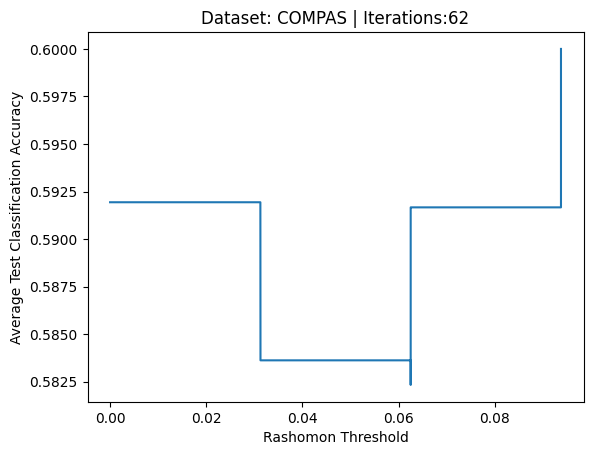

In [4]:
### Plot Accuracy ###
plt.plot(ThresholdValues_Mean, Epsilon_ClassAccuracy_Mean, label="Average Classification Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test Classification Accuracy")
plt.title("Dataset: " + Dataset + " | Iterations:" +str(ThresholdValuesALL.shape[0]))
# plt.xticks(np.arange(0, 0.05, 0.005)) 
plt.show()

# F1 by Rashomon Threshold

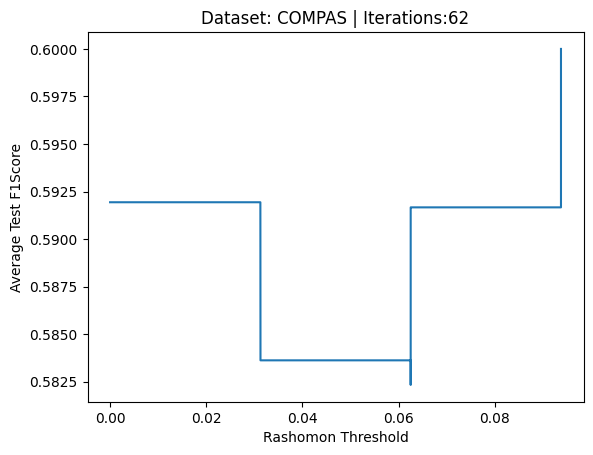

In [5]:
plt.plot(ThresholdValues_Mean, Epsilon_F1Score_Mean, label="Average F1 Score Accuracy")
plt.xlabel("Rashomon Threshold")
plt.ylabel("Average Test F1Score")
plt.title("Dataset: " + Dataset + " | Iterations:" +str(ThresholdValuesALL.shape[0]))
# plt.xticks(np.arange(0, 0.05, 0.005)) 
plt.show()

---

In [9]:
### Import Packages ###
import os
import argparse
import numpy as np
import math as math
import pandas as pd
from scipy import stats
import random as random
from sklearn.metrics import f1_score
from treeFarms.treefarms.model.treefarms import TREEFARMS

### IMPORT FUNCTIONS ###
from utils.Auxiliary import *


### SET UP ###

# Input #
DataFile = "COMPAS"
rashomon_bound_adder = 0.04
regularization = 0.01
TestProportion = 0.2
CandidateProportion = 0.8
Seed = 0

# Load Data #
df = LoadData(DataFile)
random.seed(Seed)
np.random.seed(Seed)

# Train Test Candidate Split #
from utils.Main import TrainTestCandidateSplit
df_Train, df_Test, df_Candidate = TrainTestCandidateSplit(df, TestProportion, CandidateProportion)


In [10]:
print(DataFile + " & " + str(df.shape[0]) + " & " + str(df_Test.shape[0]) + " & " + str(df_Train.shape[0]) + " & " + str(df_Candidate.shape[0]) + "\\\\")

COMPAS & 200 & 40 & 32 & 128\\


In [ ]:

### TRAIN TREEFARMS ###
# TreeFarms #
config = {"regularization": regularization, "rashomon_bound_adder": rashomon_bound_adder}
TreeFarmsModel = TREEFARMS(config)
TreeFarmsModel.fit(df_Train.loc[:, df_Train.columns != "Y"], df_Train["Y"])
TreeCount = TreeFarmsModel.get_tree_count()
print("Number of trees:" + str(TreeCount))

# Duplicate and Unique #
PredictionArray_Duplicate = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Train.loc[:, df_Train.columns != "Y"]) for i in range(TreeCount)]))
PredictionArray_Unique = pd.DataFrame(PredictionArray_Duplicate).drop_duplicates(keep='first', ignore_index=False)
TrueValues = df_Train["Y"].to_numpy()
PredictionArray = PredictionArray_Unique

### TRAINING ACCURACY ###
# Training Accuracy #
TreeClassificationAccuracy = PredictionArray.eq(TrueValues, axis=1).mean(axis=1)
BestAccuracy = float(np.max(TreeClassificationAccuracy))

# Threshold Values #
EpsilonVec = BestAccuracy - TreeClassificationAccuracy
MinEpsilon = float(np.min(EpsilonVec))
MaxEpsilon = float(np.max(EpsilonVec))
ThresholdValues = np.linspace(MinEpsilon, MaxEpsilon, 10000)
ThresholdValues = np.arange(MinEpsilon, MaxEpsilon + 0.000001, 0.000001)


### TEST ACCURACY ###
# Set Up #
ModelIndicesVec = []
Epsilon_F1Score = []
Epsilon_ClassAccuracy = []
ModelIndicesOld = []  # Initialize as empty list
F1ScoreOld = None
ClassAccuracyOld = None


for Threshold in ThresholdValues:

    # Filter Models Based on Threshold
    ModelIndices = EpsilonVec[EpsilonVec <= Threshold].index.tolist()

    # Only recalculate F1 and Class Accuracy if new models were added
    if ModelIndices == ModelIndicesOld:
        # Use stored values
        F1Score = F1ScoreOld
        ClassAccuracy = ClassAccuracyOld
    else: 
        # Test Set Predictions
        Test_Predictions = pd.DataFrame(
            np.array([TreeFarmsModel[i].predict(df_Test.loc[:, df_Test.columns != "Y"]) for i in ModelIndices])
        )
        Test_Predictions.columns = df_Test.index.astype(str)

        # Compute Ensemble Prediction (Mode)
        mode_result = stats.mode(Test_Predictions, axis=0, keepdims=True)
        EnsemblePrediction = pd.Series(mode_result.mode.flatten())
        EnsemblePrediction.index = df_Test.index

        # Compute Metrics
        F1Score = float(f1_score(df_Test["Y"], EnsemblePrediction, average='micro'))
        ClassAccuracy = float(np.mean(EnsemblePrediction == df_Test["Y"]))

        # Store Old ModelIndices
        ModelIndicesOld = ModelIndices.copy()
        F1ScoreOld = F1Score
        ClassAccuracyOld = ClassAccuracy

    # Append Metrics
    ModelIndicesVec.append(ModelIndices)
    Epsilon_F1Score.append(F1Score)
    Epsilon_ClassAccuracy.append(ClassAccuracy)